In [ ]:
# Baseline Model for Sales Forecasting with Holidays

This notebook implements the baseline model for forecasting sales using the Prophet library, incorporating holiday effects to improve predictions.

/var/folders/mh/j3zy8xqx2v32dk0tv4nx5x8m0000gn/T/ipykernel_6552/3431893297.py:12: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  sales_train_processed = pd.read_csv(train_path)
/var/folders/mh/j3zy8xqx2v32dk0tv4nx5x8m0000gn/T/ipykernel_6552/3431893297.py:13: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  sales_test_processed = pd.read_csv(test_path)
09:56:24 - cmdstanpy - INFO - Chain [1] start processing
09:56:25 - cmdstanpy - INFO - Chain [1] done processing
/Users/alexanderschou/Library/Caches/pypoetry/virtualenvs/at2-experimentation-YINVk6u--py3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean Absolute Error (MAE): 10322.531047595368
Root Mean Squared Error (RMSE): 14429.292297422795
Mean Absolute Percentage Error (MAPE): 955.95%


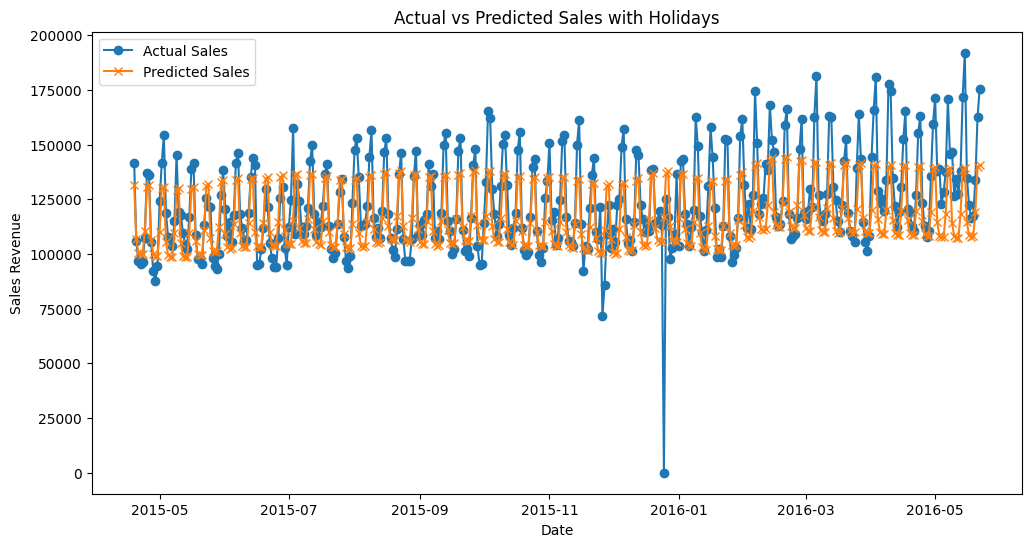

In [2]:
# Import necessary libraries
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import joblib
import os
import matplotlib.pyplot as plt

# Function to load data
def load_data(train_path, test_path):
    try:
        sales_train_processed = pd.read_csv(train_path)
        sales_test_processed = pd.read_csv(test_path)
        return sales_train_processed, sales_test_processed
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None

# Function to preprocess data
def preprocess_data(sales_train, sales_test):
    sales_train['date'] = pd.to_datetime(sales_train['date'])
    sales_test['date'] = pd.to_datetime(sales_test['date'])

    daily_sales_train = sales_train.groupby('date')['revenue'].sum().reset_index()
    daily_sales_train.rename(columns={'date': 'ds', 'revenue': 'y'}, inplace=True)

    daily_sales_test = sales_test.groupby('date')['revenue'].sum().reset_index()
    daily_sales_test.rename(columns={'date': 'ds', 'revenue': 'y'}, inplace=True)

    return daily_sales_train, daily_sales_test

# Function to create holidays DataFrame
def create_holidays_dataframe(sales_train):
    holidays = sales_train[['event_name', 'date']].dropna().drop_duplicates()
    holidays['ds'] = pd.to_datetime(holidays['date'])
    holidays['holiday'] = holidays['event_name']  # Use event names as holiday names
    holidays = holidays[['ds', 'holiday']]  # Keep only necessary columns
    return holidays

# Function to fit the Prophet model with holidays
def fit_prophet_model(train_data, holidays):
    model = Prophet(holidays=holidays)
    model.fit(train_data)
    return model

# Function to evaluate the model
def evaluate_model(test_data, forecast_data):
    mae = mean_absolute_error(test_data['y'], forecast_data['yhat'])
    rmse = mean_squared_error(test_data['y'], forecast_data['yhat'], squared=False)
    mape = mean_absolute_percentage_error(test_data['y'], forecast_data['yhat']) * 100

    return mae, rmse, mape

# Function to plot forecast
def plot_forecast(actual, forecast):
    plt.figure(figsize=(12, 6))
    plt.plot(actual['ds'], actual['y'], label='Actual Sales', marker='o')
    plt.plot(forecast['ds'], forecast['yhat'], label='Predicted Sales', marker='x')
    plt.title('Actual vs Predicted Sales with Holidays')
    plt.xlabel('Date')
    plt.ylabel('Sales Revenue')
    plt.legend()
    plt.show()

# Set working directory and file paths
os.chdir("/Users/alexanderschou/Desktop/Projects/adv_mla_2024/AT2_experimentation/data/processed")
train_path = 'sales_train_processed.csv'
test_path = 'sales_test_processed.csv'

# Load and preprocess data
sales_train, sales_test = load_data(train_path, test_path)
if sales_train is None or sales_test is None:
    raise Exception("Failed to load data")

daily_sales_train, daily_sales_test = preprocess_data(sales_train, sales_test)

# Create holidays dataframe
holidays_df = create_holidays_dataframe(sales_train)

# Fit the model with holidays
model = fit_prophet_model(daily_sales_train, holidays_df)

# Make predictions
future_test = model.make_future_dataframe(periods=len(daily_sales_test), include_history=False)
forecast_test = model.predict(future_test)

# Evaluate the model
forecast_test_filtered = forecast_test[['ds', 'yhat']].head(len(daily_sales_test))
evaluation_df = pd.merge(daily_sales_test, forecast_test_filtered, on='ds')
mae, rmse, mape = evaluate_model(evaluation_df, forecast_test_filtered)

# Print evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Plot results
plot_forecast(daily_sales_test, forecast_test_filtered)

# Save the model
joblib.dump(model, 'prophet_sales_model_baseline_with_holidays.pkl')


In [ ]:
# Baseline Model for Sales Forecasting with US Country Holidays

This section implements the baseline model for forecasting sales using the Prophet library, incorporating US country holidays to see if this improves predictions compared to the previous model.


10:02:14 - cmdstanpy - INFO - Chain [1] start processing
10:02:15 - cmdstanpy - INFO - Chain [1] done processing
/Users/alexanderschou/Library/Caches/pypoetry/virtualenvs/at2-experimentation-YINVk6u--py3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean Absolute Error (MAE) with US Holidays: 9527.637693924014
Root Mean Squared Error (RMSE) with US Holidays: 12524.599102674558
Mean Absolute Percentage Error (MAPE) with US Holidays: 204.86%


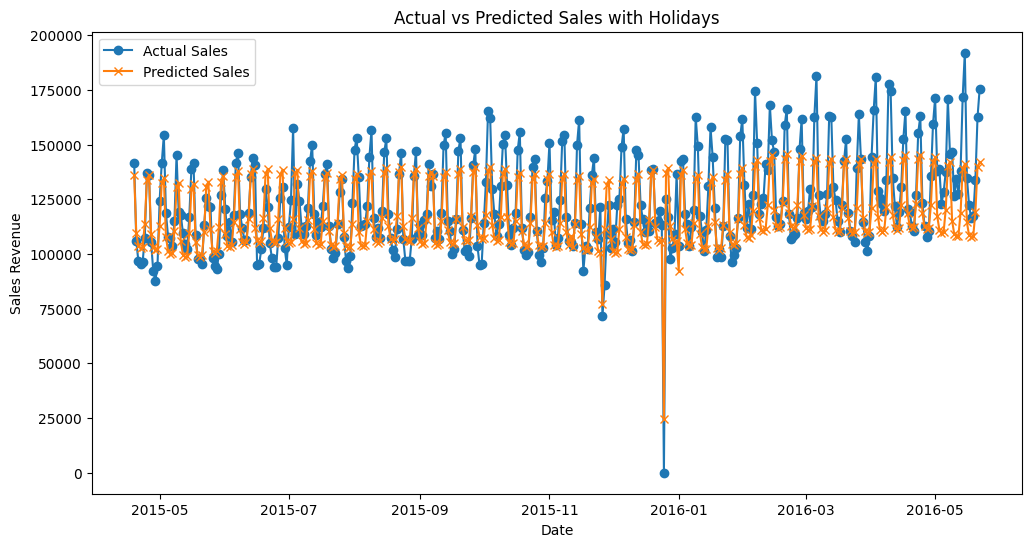

In [3]:
# Function to fit the Prophet model with US country holidays
def fit_prophet_with_country_holidays(train_data):
    model = Prophet()
    model.add_country_holidays(country_name='US')  # Automatically add US holidays
    model.fit(train_data)
    return model

# Fit the model with US country holidays
model_with_country_holidays = fit_prophet_with_country_holidays(daily_sales_train)

# Make predictions
future_test_with_country_holidays = model_with_country_holidays.make_future_dataframe(periods=len(daily_sales_test), include_history=False)
forecast_test_with_country_holidays = model_with_country_holidays.predict(future_test_with_country_holidays)

# Evaluate the model
forecast_test_filtered_with_country_holidays = forecast_test_with_country_holidays[['ds', 'yhat']].head(len(daily_sales_test))
evaluation_df_with_country_holidays = pd.merge(daily_sales_test, forecast_test_filtered_with_country_holidays, on='ds')
mae_country, rmse_country, mape_country = evaluate_model(evaluation_df_with_country_holidays, forecast_test_filtered_with_country_holidays)

# Print evaluation metrics
print(f"Mean Absolute Error (MAE) with US Holidays: {mae_country}")
print(f"Root Mean Squared Error (RMSE) with US Holidays: {rmse_country}")
print(f"Mean Absolute Percentage Error (MAPE) with US Holidays: {mape_country:.2f}%")

# Plot results
plot_forecast(daily_sales_test, forecast_test_filtered_with_country_holidays)

# Save the model
joblib.dump(model_with_country_holidays, 'prophet_sales_model_baseline_with_country_holidays.pkl')
